In [1]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO
from pathlib import Path

In [2]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34
torch.backends.cudnn.benchmark=True

## Models

In [3]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [4]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [5]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [6]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [7]:
def cut_model(m, cut):
    return list(m.children())[:cut] if cut else [m]

def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [8]:

model_meta = {
    resnet18:[8,6], resnet34:[8,6]
}

In [9]:
f = resnet34
cut,lr_cut = model_meta[f]

In [10]:
m = get_base()
m = Unet34(m)

In [11]:
PATH = Path('../data/Train')

In [35]:
cuda_enabled = torch.cuda.is_available()
model_path = str(PATH/'models/600urn-96-crop.h5')
if cuda_enabled:
    m = m.cuda()
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
else:
    m.load_state_dict(torch.load(model_path))


In [63]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
  print ("Error loading video")
  quit

# Define encoder function
def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)


In [64]:
import matplotlib.pyplot as plt

In [65]:
(546-194)

352

In [66]:
194+32

226

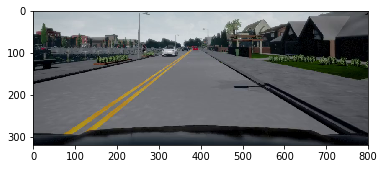

In [67]:
plt.imshow(video[0][226:546,:,:])

In [68]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [69]:
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
def normalize(x):
    x = x.astype(np.float32)
    if np.mean(x) > 1:
        x /= 255.0
    m,s = imagenet_stats
    x -= m
    x /= s
    return x
def preprocess(video):
#     f1 = video[:,200:520,:,:]
    f1 = video[:,226:546,:,:]
    f1 = normalize(f1)
    f1 = np.rollaxis(f1, 3, 1)
    return f1.copy(order='C')

In [70]:
video_p = preprocess(video)

In [71]:
video_p.shape

(31, 3, 320, 800)

In [72]:
import gc
gc.collect()

0

In [73]:
xv = torch.autograd.Variable(torch.from_numpy(video_p).contiguous().float())

In [74]:
results = []
answer_key = {}
bs = 4
for i in range(0,video_p.shape[0],bs):
    f1 = video_p[i:i+bs]
    print(f1.shape)
    
    xv = torch.autograd.Variable(torch.from_numpy(f1).contiguous().float())
    if cuda_enabled:
        xv = xv.cuda()
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    
    idx = F.pad(idx, (0,0,226,54), "constant", 0)
    print(idx.shape)
    
    # Frame numbering starts at 1
    frame_idx = 1+i
    for frame in idx:
        # Look for red cars :)
        frame = frame.data.cpu().numpy()
        results.append(frame)
        binary_car_result = (frame==1).astype('uint8')

        # Look for road :)
        binary_road_result = (frame==2).astype('uint8')

        answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]

        # Increment frame
        frame_idx+=1

(4, 3, 320, 800)
torch.Size([4, 600, 800])
(4, 3, 320, 800)
torch.Size([4, 600, 800])
(4, 3, 320, 800)
torch.Size([4, 600, 800])
(4, 3, 320, 800)
torch.Size([4, 600, 800])
(4, 3, 320, 800)
torch.Size([4, 600, 800])
(4, 3, 320, 800)
torch.Size([4, 600, 800])
(4, 3, 320, 800)
torch.Size([4, 600, 800])
(3, 3, 320, 800)
torch.Size([3, 600, 800])


In [75]:
results[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

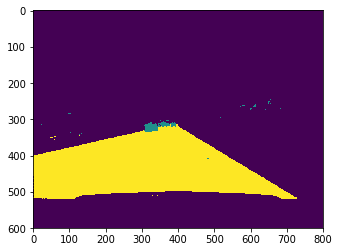

In [76]:
plt.imshow(results[0].data)

In [77]:
# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_crop', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

{"1": ["iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAAAAAC/Hd2sAAAEw0lEQVR4nO3dy3KjMBAFUHVq/v+XNQs/AhgwYAgtfM5iJjHYRQkuLYEcSgEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVomzN2Do5+wNgMwEhETSFRBIRUJgUsJ4/Dt7A6CUZzainrsZL4xByCRbPiCJKJGxi6WCkENNmI4iIGQRJWUHS0AA0svZw1JByCFuEUkaEzhQNHzYqyD8gQURSRoiASGHhFewShEQjpe0NixjLhYfeRz90wWg6Xw0vvWcL2Z7R/fj623/Kd0kxQcBYbPbwTN/aL+vMLnpYrHV4skhSadZLdLwppPTPTdpO01wppi65+FcDMDOUpcWg3SOMX/5t79iYu6kM7DPATv2KeOfvHQwf06QcseXZkUppdRYcIsw9y0SFYSD1EVHfvJ8AAAAAAAAAAA9h8/Fav07yQDAl9i1V2Q2LwAAAAAAtK/l5wgeSbOw/M+0fyE3CimlOFNOERBKKSoIAAAAX+D1/oLrRS3xAJ1jTTwmwzWjVrjMe6jXfNwqiirSCgE5XHT+BUYJSJvst6NFvTeycUeLdLGOF4P/+wudolKzez53e17l3MKnOlhW75e0XNjKSkA+1WvB2n0oZdx+f7z+WGP0jQKSlC7WZwYFIp4vRdwrw2A1Xaq22F2f6LRe/X2pdpfV0Rau5bXplZCMVJAPjBz7MbNs/p2kNLGnPN79ree128cXVvvlJKaKR3el4QCGdCbn